In [ ]:
# !uv pip install dash

In [1]:
"""
Step 1. Load data
"""
from utils.trial import load_trial

# Edit these values
SUBJECTS_DIR = "subjects"
SUBJECT_NAME = "ncbc_s15"
TRIAL_NAME = "TM_p9"
RESULTS_FILE = "results.json"
# ================================

trial = load_trial(SUBJECTS_DIR, SUBJECT_NAME, TRIAL_NAME)
SUBJECT_WEIGHT = trial.subject_weight

sensors = trial.load_sensors()
treadmill_unaligned = trial.load_treadmill()

In [ ]:
"""
Step 2. Use the alignment tool to find signal offsets.
Only uncomment one side at a time.
"""
from utils.viz import visually_align_signal

# Uncomment below to align left ankle and left force signals
SENSOR_SIGNAL = sensors.left_df['accel_filtered']
TREADMILL_SIGNAL = treadmill_unaligned.left_df['vgrf']

# Uncomment below to align right ankle and right force signals
# SENSOR_SIGNAL = sensors.right_df['accel_filtered']
# TREADMILL_SIGNAL = treadmill_unaligned.right_df['vgrf'] 

visually_align_signal(SENSOR_SIGNAL, TREADMILL_SIGNAL)

In [2]:
"""
Step 3. Align sensor and treadmill signals.

Use the above cell to visually determine offsets for the treadmill signals.
After you do that, update the values of LEFT_VGRF_OFFSET and RIGHT_VGRF_OFFSET.
"""

import pandas as pd
from utils.treadmill import TreadmillData

# for subject ncbc_s10, trial TMp6,   offset = 780
# for subject ncbc_s15, trial TMp6,   offset = 430

LEFT_VGRF_OFFSET = 430    # INPUT VALUE FROM STEP 2!
RIGHT_VGRF_OFFSET = 430    # INPUT VALUE FROM STEP 2!

def apply_offset(treadmill_df: pd.DataFrame, offset: int):
    """
    Applies an offset to treadmill_df
    """
    if offset < 0:
        out_df = treadmill_df.iloc[-offset:]
    elif offset > 0:
        padding = pd.DataFrame({'time': [0]*offset, 'vgrf': [0]*offset})
        out_df = pd.concat([padding, treadmill_df])
    else:
        out_df = treadmill_df
    return out_df.reset_index(drop=True)

left_df = apply_offset(treadmill_unaligned.left_df, LEFT_VGRF_OFFSET)
right_df = apply_offset(treadmill_unaligned.right_df, RIGHT_VGRF_OFFSET)

treadmill = TreadmillData(left_df, right_df)

ACCEL STRIKES: [690, 1735, 1870, 1994, 2118, 2204, 2296, 2398, 2505, 2587, 2681, 2776, 2872, 2974, 3081, 3169, 3266, 3365, 3461, 3613, 3669, 3755, 3859, 3949, 4054, 4139, 4240, 4337, 4408, 4430, 4527, 4624, 4727, 4828, 4915, 5008, 5115, 5203, 5308, 5405, 5494, 5593, 5696, 5788, 5878, 5979, 6082, 6193, 6278, 6495, 6594, 6677, 6772, 6880, 6972, 7068, 7179, 7266, 7367, 7473, 7578, 7664, 7776, 7860, 7962, 8065, 8164, 8261, 8351, 8456, 8581, 8655, 8767, 8863, 8956, 9075, 9163, 9255, 9353, 9456, 9559, 9657, 9761, 9866, 9972, 10057, 10150, 10246, 10343, 10462, 10541, 10646, 10749, 10843, 10960, 11051, 11136, 11232, 11329, 11436, 11548, 11633, 11727, 11829, 11926, 12034, 12131, 12223, 12332, 12420, 12512, 12727, 12824, 12925, 13006, 13094, 13212, 13297, 13392, 13506, 13589, 13683, 13774, 13891, 13968, 14064, 14161, 14275, 14353, 14451, 14546, 14643, 14737, 14832, 14930, 15025, 15119, 15214, 15317, 15403, 15521, 15658, 15785]
ACCEL STANCES: [0     0.912751
1     0.904433
2     0.896004
3     0.

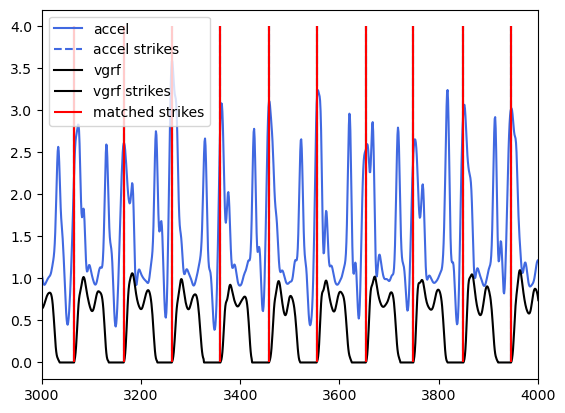

In [3]:
"""
Step 3. Extract strike indices and stances from the left.
"""
import matplotlib.pyplot as plt
from operator import itemgetter
from utils.stance import parse_and_match_stances
from utils.config import PipelineConfig

# You can uncomment and change the config to see how it affects the results.
#  See all parameters in utils/config.py

config = PipelineConfig(
    accel_peak_params={
        'height': 1.0,
        'prominence': 0.5,
        'width': 5.0,
        'distance': 10
    },
    jerk_peak_params={
        'height': 0.0,
        'prominence': 0.1
    },
    jerk_window_size=50,
    stance_matching_time_threshold=50,
    accel_filters=[],
    vgrf_filters=[],
    min_stance_size=80,
    max_stance_size=140
)

left_strikes, left_stances, debug = parse_and_match_stances(
    sensors.left_df['accel_filtered'],
    sensors.left_df['accel'],
    sensors.waist_df['accel_filtered'],
    treadmill.left_df['vgrf'],
    config # <--- Uncomment to use your own config
)


# Plot accel
plt.plot(sensors.left_df['accel_filtered'], color='royalblue',label='accel')
plt.vlines(debug['accel_strikes'], 0, 4, color='royalblue', linestyle='--', label='accel strikes')

# Plot vgrf
plt.plot(treadmill.left_df['vgrf'], color='black', label='vgrf')
plt.vlines(debug['vgrf_strikes'], 0, 4, color='black', label='vgrf strikes')

# Plot matched strikes
plt.vlines(list(map(itemgetter(0), left_strikes)), 0, 4, color='red', label='matched strikes')

# show plot
#plt.xlim(2000,3000)
#plt.xlim(16000,17500)
plt.xlim(3000,4000)
#plt.xlim(1000, 2500)
plt.legend()
plt.show()


# NOTE: Dropping filters and increasing stance_matching_time_threshold from 5 -> 10
# will cause more strikes to be matched.

ACCEL STRIKES: [607, 716, 1789, 1920, 2026, 2134, 2227, 2327, 2418, 2513, 2611, 2709, 2799, 2902, 2994, 3103, 3197, 3294, 3389, 3488, 3584, 3678, 3797, 3879, 3975, 4076, 4162, 4259, 4364, 4456, 4549, 4667, 4742, 4853, 4935, 5030, 5127, 5229, 5318, 5436, 5519, 5625, 5714, 5807, 5906, 6020, 6111, 6205, 6305, 6402, 6498, 6601, 6702, 6815, 6898, 6992, 7095, 7201, 7297, 7389, 7489, 7598, 7694, 7799, 7889, 7999, 8086, 8186, 8300, 8383, 8482, 8583, 8697, 8780, 8878, 8984, 9082, 9182, 9278, 9380, 9483, 9585, 9687, 9784, 9880, 9979, 10077, 10174, 10271, 10370, 10472, 10585, 10670, 10770, 10867, 10967, 11079, 11159, 11262, 11361, 11465, 11561, 11661, 11754, 11854, 11946, 12050, 12144, 12244, 12347, 12460, 12538, 12637, 12736, 12830, 12929, 13043, 13125, 13220, 13322, 13418, 13535, 13609, 13711, 13805, 13898, 13995, 14095, 14187, 14285, 14392, 14477, 14572, 14669, 14761, 14859, 14953, 15043, 15141, 15238, 15331, 15428, 15562, 15713, 15820, 16006]
ACCEL STANCES: [0     1.018151
1     1.013149
2   

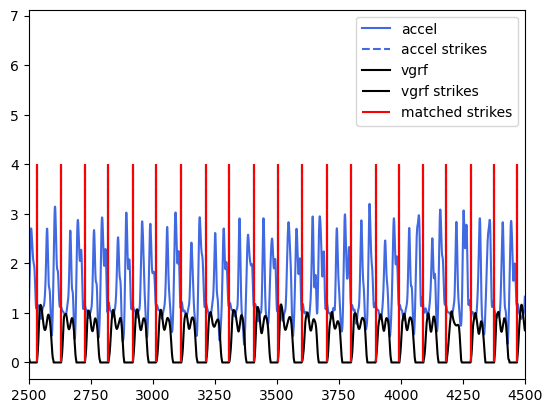

In [4]:
"""
Step 4. Extract strike indices and stances from the right.
"""

import matplotlib.pyplot as plt
from operator import itemgetter
from utils.stance import parse_and_match_stances
from utils.config import PipelineConfig

# You can uncomment and change the config to see how it affects the results.
#  See all parameters in utils/config.py

config = PipelineConfig(
    accel_peak_params={
        'height': 1.0,
        'prominence': 0.5,
        'width': 5.0,
        'distance': 10
    },
    jerk_peak_params={
        'height': 0.0,
        'prominence': 0.1
    },
    jerk_window_size=50,
    stance_matching_time_threshold=50,
    accel_filters=[],
    vgrf_filters=[],
    min_stance_size=80,
    max_stance_size=140
)


right_strikes, right_stances, debug = parse_and_match_stances(
    sensors.right_df['accel_filtered'],
    sensors.right_df['accel'],
    sensors.waist_df['accel_filtered'],
    treadmill.right_df['vgrf'],
    config # <--- Uncomment to use your own config
)

# Plot accel
plt.plot(sensors.right_df['accel_filtered'], color='royalblue',label='accel')
plt.vlines(debug['accel_strikes'], 0, 4, color='royalblue', linestyle='--', label='accel strikes')

#plt.plot(sensors.waist_df['accel_filtered'], color='pink', label=)
# Plot vgrf
plt.plot(treadmill.right_df['vgrf'], color='black', label='vgrf')
plt.vlines(debug['vgrf_strikes'], 0, 4, color='black', label='vgrf strikes')

# Plot matched strikes
plt.vlines(list(map(itemgetter(0), right_strikes)), 0, 4, color='red', label='matched strikes')

# show plot
plt.xlim(2500, 4500)
plt.legend()
plt.show()

# NOTE: This side looks like it has good peak detection, but the strikes between the treadmill and sensors
# are not matching up.

In [ ]:
"""
Step 5. Merge both sides and run through the model.
"""
import csv
import os
from utils.predict import predict_stance
from utils.output import make_peak_results, make_stance_results

RESULTS_DIR = os.path.join('results', SUBJECT_NAME, TRIAL_NAME) 

REF_PEAKS_FILE = os.path.join(RESULTS_DIR, 'reference_peaks.xlsx')
PRED_PEAKS_FILE = os.path.join(RESULTS_DIR, 'pred_peaks.xlsx')
REF_STANCES_FILE_LEFT = os.path.join(RESULTS_DIR, 'reference_waveforms_L.xlsx')
REF_STANCES_FILE_RIGHT = os.path.join(RESULTS_DIR, 'reference_waveforms_R.xlsx')
PRED_STANCES_FILE_LEFT = os.path.join(RESULTS_DIR, 'pred_waveforms_L.xlsx')
PRED_STANCES_FILE_RIGHT = os.path.join(RESULTS_DIR, 'pred_waveforms_R.xlsx')

if not os.path.exists(RESULTS_DIR):
#     print(f"A directory called {RESULTS_DIR}/ already exists")
# else:
    os.makedirs(RESULTS_DIR)

left_accel_stances = list(map(itemgetter(0), left_stances)) 
left_vgrf_stances = list(map(itemgetter(1), left_stances))
right_accel_stances = list(map(itemgetter(0), right_stances))
right_vgrf_stances = list(map(itemgetter(1), right_stances))

# Use the MLP model to predict vGRF stances from accel stances
left_vgrf_pred_stances = list(map(predict_stance, left_accel_stances))
right_vgrf_pred_stances = list(map(predict_stance, right_accel_stances))

# Create reference and predicted peak results
ref_peak_results = make_peak_results(left_vgrf_stances, right_vgrf_stances)
ref_peak_results.to_excel(REF_PEAKS_FILE, index=False)

pred_peak_results = make_peak_results(left_vgrf_pred_stances, right_vgrf_pred_stances)
pred_peak_results.to_excel(PRED_PEAKS_FILE, index=False)

# Create reference and predicted stance (waveform) results
left_vgrf_stances = pd.DataFrame(left_vgrf_stances)
left_vgrf_stances_T = left_vgrf_stances.T

right_vgrf_stances = pd.DataFrame(right_vgrf_stances)
right_vgrf_stances_T = right_vgrf_stances.T

left_vgrf_results = pd.DataFrame(left_vgrf_stances_T)
left_vgrf_results.columns = [f"step_{i+1}" for i in range(left_vgrf_results.shape[1])]
left_vgrf_results.to_excel(REF_STANCES_FILE_LEFT, index=False)
right_vgrf_results = pd.DataFrame(right_vgrf_stances_T)
right_vgrf_results.columns = [f"step_{i+1}" for i in range(right_vgrf_results.shape[1])]
right_vgrf_results.to_excel(REF_STANCES_FILE_RIGHT, index=False)

left_vgrf_pred_stances = pd.DataFrame(left_vgrf_pred_stances)
left_vgrf_pred_stances_T = left_vgrf_pred_stances.T
right_vgrf_pred_stances = pd.DataFrame(right_vgrf_pred_stances)
right_vgrf_pred_stances_T = right_vgrf_pred_stances.T

left_pred_waveform_results = pd.DataFrame(left_vgrf_pred_stances_T)
left_pred_waveform_results.columns = [f"step_{i+1}" for i in range(left_pred_waveform_results.shape[1])]
left_pred_waveform_results.to_excel(PRED_STANCES_FILE_LEFT, index=False)
right_pred_waveform_results = pd.DataFrame(right_vgrf_pred_stances_T)
right_pred_waveform_results.columns = [f"step_{i+1}" for i in range(right_pred_waveform_results.shape[1])]
right_pred_waveform_results.to_excel(PRED_STANCES_FILE_RIGHT, index=False)

In [ ]:
import numpy as np

random_index = np.random.randint(0, len(left_vgrf_pred_stances))

plt.plot(left_vgrf_pred_stances.T[random_index], color = "black", linestyle = "--", label = "Sensor vGRF")
plt.plot(left_vgrf_stances.T[random_index], color = "black",  label = "Treadmill vGRF")
# plt.plot(left_accel_stances[random_index], color = "blue",  label = "Acceleration Signal")
plt.legend()
plt.title("Left Sensor data example")
plt.show()

plt.figure()
plt.plot(right_vgrf_pred_stances.T[random_index], color = "black", linestyle = "--", label = "Sensor vGRF")
plt.plot(right_vgrf_stances.T[random_index], color = "black",  label = "Treadmill vGRF")
# plt.plot(right_accel_stances[random_index], color = "red",  label = "Acceleration Signal")
plt.legend()
plt.title("Right Sensor data example")
plt.show()


In [ ]:
from utils.stance import StanceAnalyzer
import matplotlib.pyplot as plt

analyzer = StanceAnalyzer() 
vgrf = treadmill.left_df['vgrf']  
start_idx, stances = analyzer.extract_treadmill_stances(vgrf)  

#vgrf
plt.figure(figsize=(10, 6))
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Normalized vGRF")
plt.xlabel("Normalized Time (%)")
plt.ylabel("vGRF (Body Weight or N)")
plt.grid(True)
plt.tight_layout()
plt.show()


r_ankle = sensors.right_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(r_ankle)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Right Ankle")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()

l_ankle = sensors.left_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(l_ankle)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Left Ankle")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()

l_waist = sensors.waist_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(l_waist)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Waist")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()